# Goal
This tutorial uses the Oxford-IIIT Pet Dataset (Parkhi et al, 2012). The dataset consists of images of 37 pet breeds, with 200 images per breed (~100 each in the training and test splits). Each image includes the corresponding labels, and pixel-wise masks. The masks are class-labels for each pixel. Each pixel is given one of three categories:


* Class 1: Pixel belonging to the pet.
* Class 2: Pixel bordering the pet.
* Class 3: None of the above/a surrounding pixel.

In [25]:
!apt remove git -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  git-man liberror-perl
Use 'apt autoremove' to remove them.
The following packages will be REMOVED:
  git
0 upgraded, 0 newly installed, 1 to remove and 24 not upgraded.
After this operation, 36.6 MB disk space will be freed.
(Reading database ... 122303 files and directories currently installed.)
Removing git (1:2.25.1-1ubuntu3.10) ...


In [26]:
!apt-get install git -y && git clone https://github.com/tensorflow/examples.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  gettext-base git-daemon-run | git-daemon-sysvinit git-doc git-el git-email
  git-gui gitk gitweb git-cvs git-mediawiki git-svn
The following NEW packages will be installed:
  git
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 4,534 kB of archives.
After this operation, 36.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 git amd64 1:2.25.1-1ubuntu3.10 [4,534 kB]
Fetched 4,534 kB in 2s (2,373 kB/s)
Selecting previously unselected package git.
(Reading database ... 121556 files and directories currently installed.)
Preparing to unpack .../git_1%3a2.25.1-1ubuntu3.10_amd64.deb ...
Unpacking git (1:2.25.1-1ubuntu3.10) ...
Setting up git (1:2.25.1-1ubuntu3.10) ...
fatal: destination path 'examples' already exists and is not an empty directory.


In [27]:
import tensorflow as tf

import tensorflow_datasets as tfds

In [28]:
from examples.tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Download the Oxform-IIIT Pets dataset

In [29]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

The pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, substract 1 from the segmentation mask, resulting in labels that are: {0, 1, 2}.

In [30]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [31]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
      datapoint['segmentation_mask'],
      (128, 128),
      method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

The dataset already contains the required training and test splits, so continue to use the same splits.

In [32]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [33]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

The following class performs a simple augmentation by randomly-flipping an image.

In [34]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # Bith use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_inputs(labels)
    return inputs, labels

Build the input pipepline, applying the augmentation after batching the inputs:

In [35]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

Visualize an image example and its corresponding mask from the dataset:

In [40]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

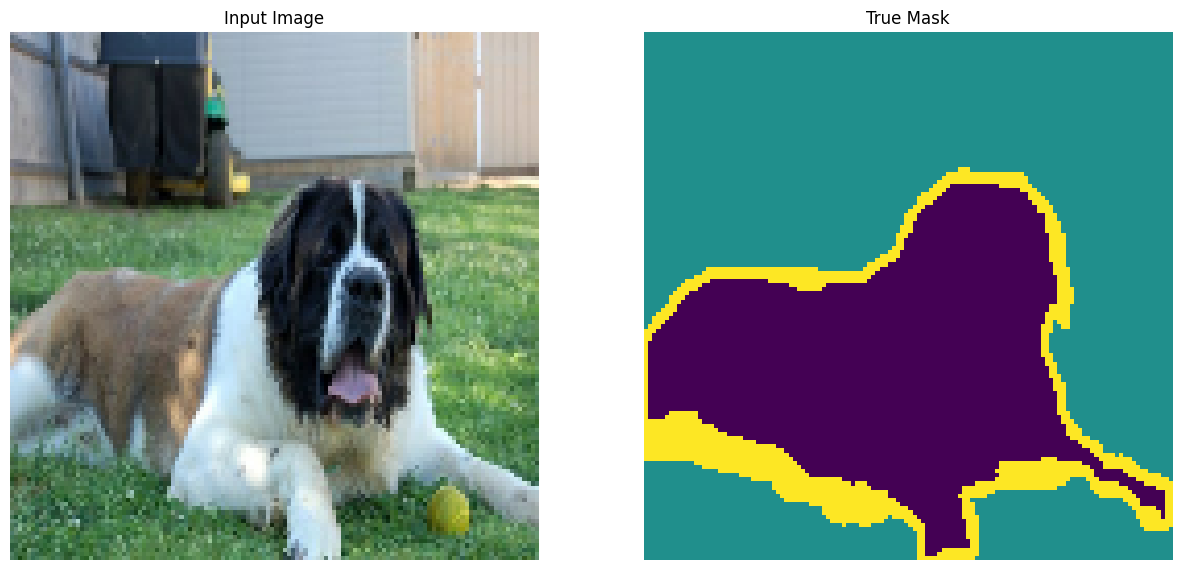

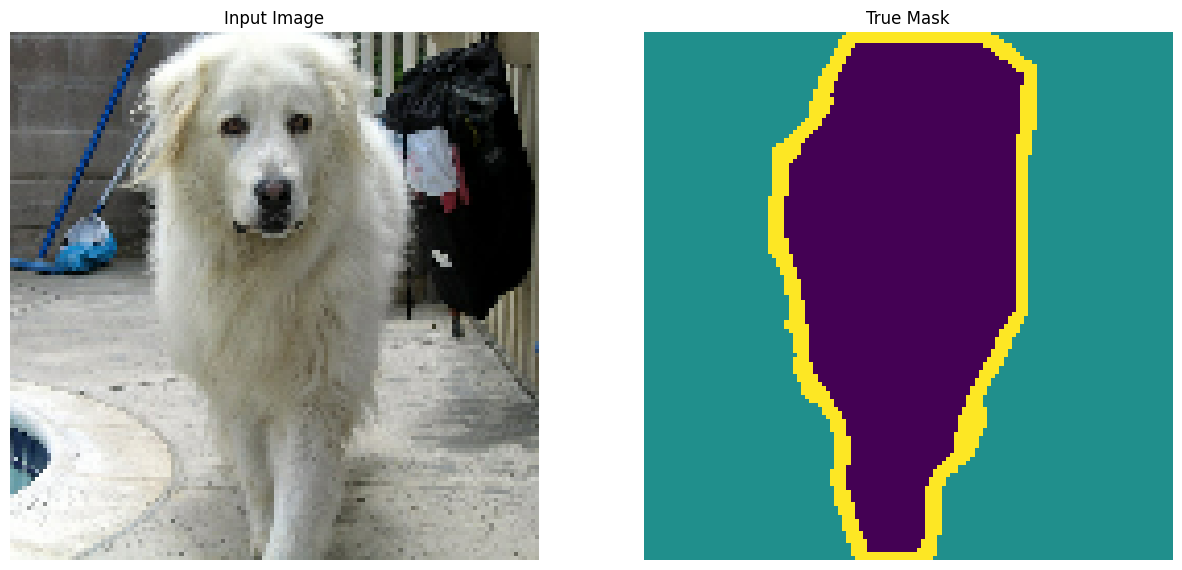

In [42]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

# Define the model

The model being used here is a modified `U-Net`. A U-Net consists of an encoder (downsampler) and decoder (upsampler).

In [47]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [48]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [52]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling throught the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')
  
  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

# Train the model

In [53]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

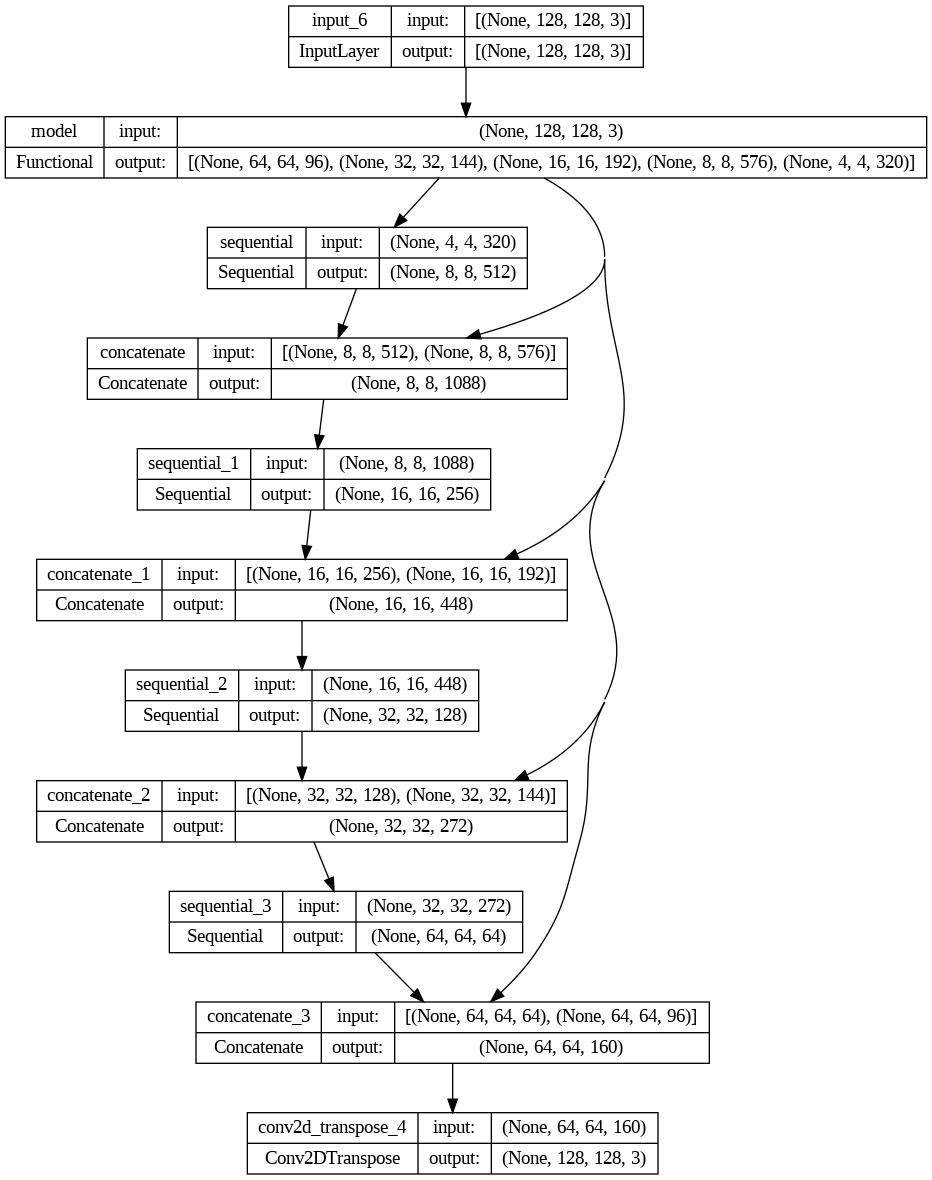

In [54]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [55]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [56]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 9s 9s/step


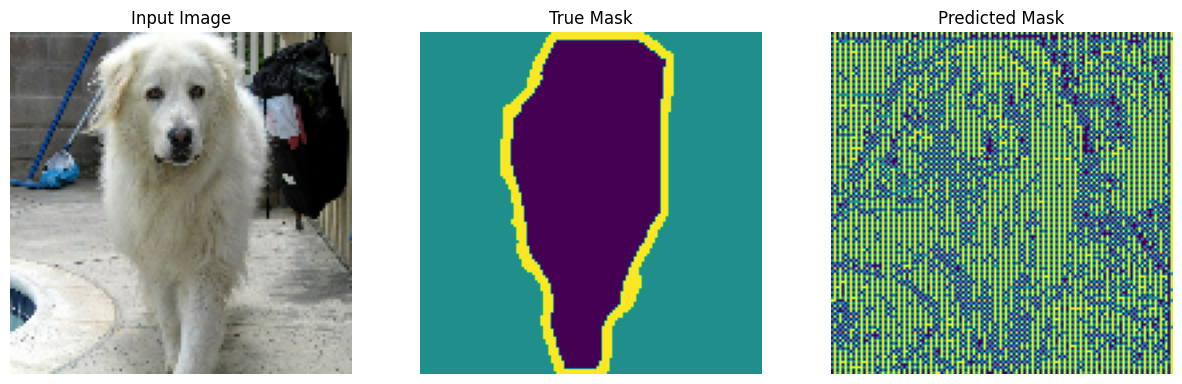

In [57]:
show_predictions()

In [58]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 25ms/step


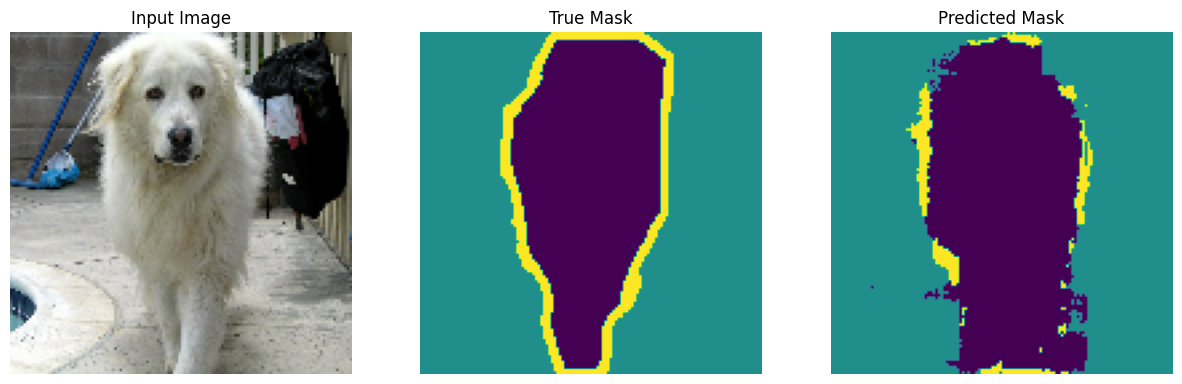


Sample Prediction after epoch 19

57/57 [==============================] - 13s 221ms/step - loss: 0.4934 - accuracy: 0.7991 - val_loss: 0.3790 - val_accuracy: 0.8626
Epoch 20/20
54/57 [===========================>..] - ETA: 0s - loss: 0.4857 - accuracy: 0.8020

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

2/2 [==============================] - 0s 60ms/step


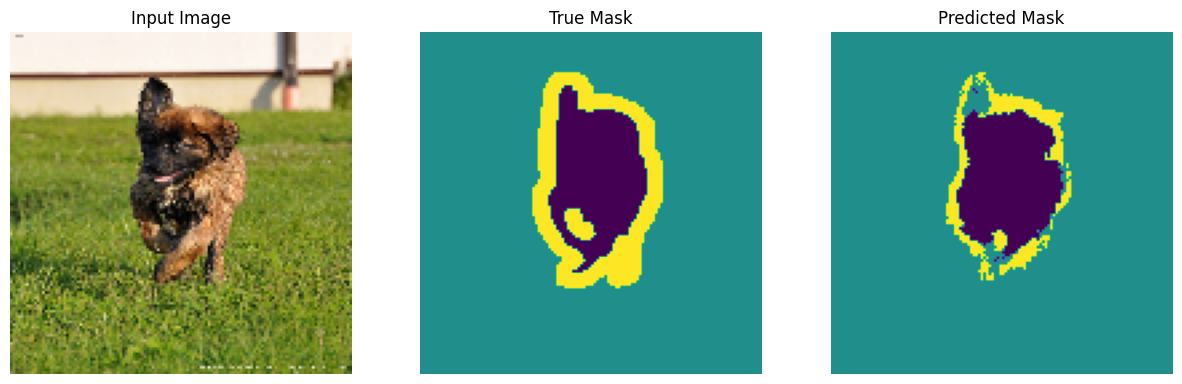

2/2 [==============================] - 0s 46ms/step


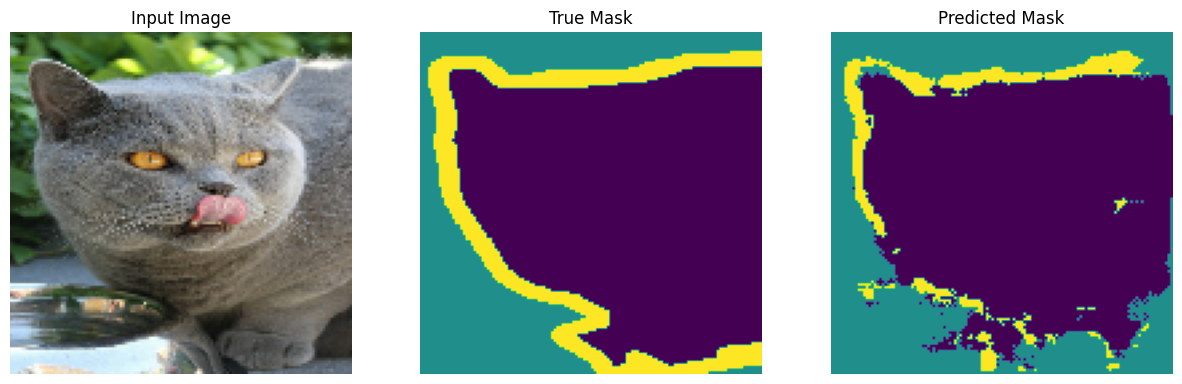

2/2 [==============================] - 0s 40ms/step


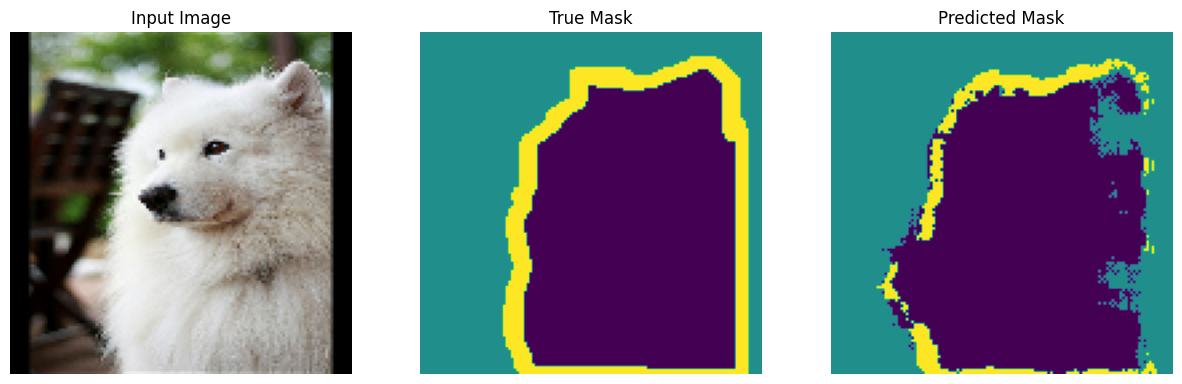

In [ ]:
show_predictions(test_batches, 3)